# Computer Vision Coursework Submission (IN3060)

**Student name, ID and cohort:** John Doe (200056789) - UG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_UG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_UG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Mask-Or-No-Mask'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Personal_Dataset', 'Models', '.DS_Store', '.git', '.gitattributes', '.idea', 'Labs', 'readme.md', 'dataset_as_pkl', '.gitignore', 'test function.py', 'test_function.ipynb']


### Load packages

In the next cell you should load all the packages required to test your function.

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import torch
import torch.nn as nn

### Load model

In the next cell you should load your best performing model (this might consist of more than one file). Avoid to load it within `MaskDetection` to avoid having to reload it each time.

In [4]:
# Path to model
PERSONAL_DATASET = "/content/drive/MyDrive/Mask-Or-No-Mask/Personal_Dataset"
MODEL_PATH = "/content/drive/MyDrive/Mask-Or-No-Mask/Models"
DATASET_AS_PKL = "/content/drive/MyDrive/Mask-Or-No-Mask/dataset_as_pkl"
prototxt_path = f"{MODEL_PATH}/openCV_Face_Detection/deploy.prototxt.txt"
dnn_model_path = f"{MODEL_PATH}/openCV_Face_Detection/res10_300x300_ssd_iter_140000.caffemodel"
cnn_model_path = f"{MODEL_PATH}/CNN_model.pt"
net = cv2.dnn.readNetFromCaffe(prototxt_path, dnn_model_path)

# Define the architecture for my CNN
def my_CNN(dropout_rate = 0.01):
    class face_mask_CNN(nn.Module):
        def __init__(self, num_classes = 3):
            super(face_mask_CNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64 * 8 * 8, 512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, num_classes),
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    return face_mask_CNN()

# Load the CNN
cnn_model = my_CNN()
cnn_model.load_state_dict(torch.load((cnn_model_path), map_location=torch.device('cuda')))
cnn_model.eval()

face_mask_CNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=512, bias=True)
    (2): ReLU()
    (3): Drop

# Test MaskDetection

This section should allow to test the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [5]:
# Load the labels associated with my personal dataset
def load_labels(image_path, label_path):
    label_map = {"0": "No Mask", "1": "Mask Worn Correctly", "2": "Improperly Worn Mask"}
    specified_labels = []

    for path in image_path:
        filename = os.path.basename(path)
        image_id = os.path.splitext(filename)[0]
        label_file = os.path.join(label_path, f"{image_id}.txt")

        try:
            with open(label_file, 'r') as f:
                label_index = f.read().strip()
                label = label_map.get(label_index, "Unknown")
                specified_labels.append(label)
        except FileNotFoundError:
            specified_labels.append("Unknown")

    return specified_labels

# Select 4 random images from personal dataset
def select_images(path, count = 4):
    valid_image_extensions = ('jpg', 'jpeg', 'png')
    files = [f for f in os.listdir(path) if f.lower().endswith(valid_image_extensions)]
    chosen_images = random.sample(files, count)
    return [os.path.join(path, f) for f in chosen_images]

# Face detection using Haar Cascade and cv2.dnn
def detect_faces(images, net, confidence_threshold = 0.6, buffer_ratio = 0.15):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    face_boxes = []

    for img in images:
        original_image = img.copy()
        h, w = img.shape[:2]

        if len(img.shape) == 2 or img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # DNN face detection
        blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104.0, 177.0, 123.0))
        net.setInput(blob)
        detections = net.forward()
        box = None
        for i in range(detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > confidence_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x1, y1, x2, y2) = box.astype("int")

                # Added buffer so the final image is not just a very zoomed in face
                box_width = x2 - x1
                box_height = y2 - y1
                buffer_w = int(buffer_ratio * box_width)
                buffer_h = int(buffer_ratio * box_height)

                x1 = max(0, x1 - buffer_w)
                y1 = max(0, y1 - buffer_h)
                x2 = min(w, x2 + buffer_w)
                y2 = min(h, y2 + buffer_h)

                box = (x1, y1, x2, y2)
                face_boxes.append(box)
                break

        # If DNN fails, use Haar Cascade instead
        if box is None:
            image_to_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(image_to_gray, scaleFactor = 1.1, minNeighbors = 5, minSize = (30, 30), flags = cv2.CASCADE_SCALE_IMAGE)

            if len(faces) > 0:
                x, y, fw, fh = faces[0]

                buffer_w = int(buffer_ratio * fw)
                buffer_h = int(buffer_ratio * fh)

                x1 = max(0, x - buffer_w)
                y1 = max(0, y - buffer_h)
                x2 = min(w, x + fw + buffer_w)
                y2 = min(h, y + fh + buffer_h)

                box = (x1, y1, x2, y2)

            face_boxes.append(box)

    return face_boxes

# Crop into the image using the boxes returned from the face detection
def crop_faces(images, boxes):
    cropped = []
    for img, box in zip(images, boxes):
        # Face detected
        if box is not None:
            x1, y1, x2, y2 = box
            cropped_img = img[y1:y2, x1:x2]
            cropped.append((cropped_img, True))
        # Face not detected so just use original image
        else:
            cropped.append((img, False))

    return cropped


In [6]:
# Resize image and pad if needed
def resize_with_padding(img, target_size=(64, 64), pad_colour=0):
    # Get image height and width
    h, w = img.shape[:2]
    # Target height and width
    th, tw = target_size

    # Set interpolation function based downscaling or upscaling
    interpolation = cv2.INTER_AREA if h > th or w > tw else cv2.INTER_CUBIC

    # See if image needs padding
    if h < th or w < tw:
        # Calculate aspect ratio of input image and maintain it for maintaining that aspect ratio
        aspect_ratio = float(h) / float(w)
        if aspect_ratio > 1:
            new_w = tw
            new_h = int(new_w / aspect_ratio)
        else:
            new_h = th
            new_w = int(new_h * aspect_ratio)

        # Resize the image
        resized_img = cv2.resize(img, (new_w, new_h), interpolation=interpolation)

        # Calculate amount of padding needed, and keeping image centered
        pad_top = (th - new_h) // 2
        pad_bottom = th - new_h - pad_top
        pad_left = (tw - new_w) // 2
        pad_right = tw - new_w - pad_left

        # Add the padding (I chose black padding)
        padded_image = cv2.copyMakeBorder(resized_img, pad_top, pad_bottom, pad_left, pad_right, borderType = cv2.BORDER_CONSTANT, value = pad_colour)

        # For SIFT and ORB especially, still works with others
        padded_image = np.clip(padded_image, 0, 255).astype(np.uint8)

        return padded_image

    else:
        resized_img = cv2.resize(img, target_size, interpolation = interpolation)
        resized_img = np.clip(resized_img, 0, 255).astype(np.uint8)
        return resized_img

# Normalize pixel values and calls resize_with_padding
def resize_and_normalize_float32(images, target_size=(64, 64)):
    X = []
    for img in images:
        if img is None or img.size == 0:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        padded = resize_with_padding(img, target_size)
        normalized = padded.astype(np.float32) / 255.0
        X.append(normalized)
    return X

In [61]:
def MaskDetection(path):
    # Select 4 random images from dataset
    image_path = select_images(path)

    images = []
    for p in image_path:
        img = cv2.imread(p)
        if img is not None:
            images.append(img)

    actual_labels = load_labels(image_path, f"{PERSONAL_DATASET}")

    # Detect faces using pre-trained library model
    face_boxes = detect_faces(images, net)
    detected_faces = crop_faces(images, face_boxes)

    # Resize and normalize for CNN
    processed_imgs = []
    face_detection_failed = []


    for img, detected in detected_faces:
        # If image is empty or other error then just use a black square
        if img is None or img.size == 0:
            dummy_image = np.zeros((64, 64), dtype = np.uint8)
            tensor = torch.tensor(dummy_image, dtype = torch.float32).unsqueeze(0).unsqueeze(0) / 255
            processed_imgs.append(tensor)
        # Normal flow - process image
        else:
            img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            padded = resize_with_padding(img_grey, (64, 64))
            tensor = torch.tensor(padded, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
            processed_imgs.append(tensor)

        face_detection_failed.append(not detected)

    inputs = torch.cat(processed_imgs, dim=0)

    # Run model
    with torch.no_grad():
        outputs = cnn_model(inputs)
        predictions = torch.argmax(outputs, dim=1).tolist()

    # Map of labels
    label_map = ["No Mask", "Mask Worn Correctly", "Improperly Worn Mask"]

    # Plot results
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    font_scale = 2
    thickness = 5
    for i, ax in enumerate(axs):
        img_to_plot = images[i].copy()
        # Draw boxes over image with labels
        if face_boxes[i] is not None:
            x1, y1, x2, y2 = face_boxes[i]
            cv2.rectangle(img_to_plot, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = label_map[predictions[i]]
            (text_w, text_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
            cv2.rectangle(img_to_plot, (x1, y1 - text_h - 10), (x1 + text_w, y1), (0, 255, 0), -1)
            cv2.putText(img_to_plot, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

        # Display Face Not Detected
        if face_detection_failed[i]:
            warning = "Face Not Detected"
            (text_w, text_h), baseline = cv2.getTextSize(warning, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
            cv2.rectangle(img_to_plot, (10, 10), (10 + text_w + 10, 10 + text_h + 10), (0, 0, 255), -1)
            cv2.putText(img_to_plot, warning, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

        img_to_plot = cv2.cvtColor(img_to_plot, cv2.COLOR_BGR2RGB)
        ax.imshow(img_to_plot)

        title = f"Actual: {actual_labels[i]}"
        if face_detection_failed[i]:
            title += "Face Not Detected"
        xlabel = f"Prediction: {label_map[predictions[i]]}"

        ax.set_title(title, fontsize = 15)
        ax.set_xlabel(xlabel, fontsize = 15)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()


Then, make a call to the `MaskDetection` function to see what results it produces.

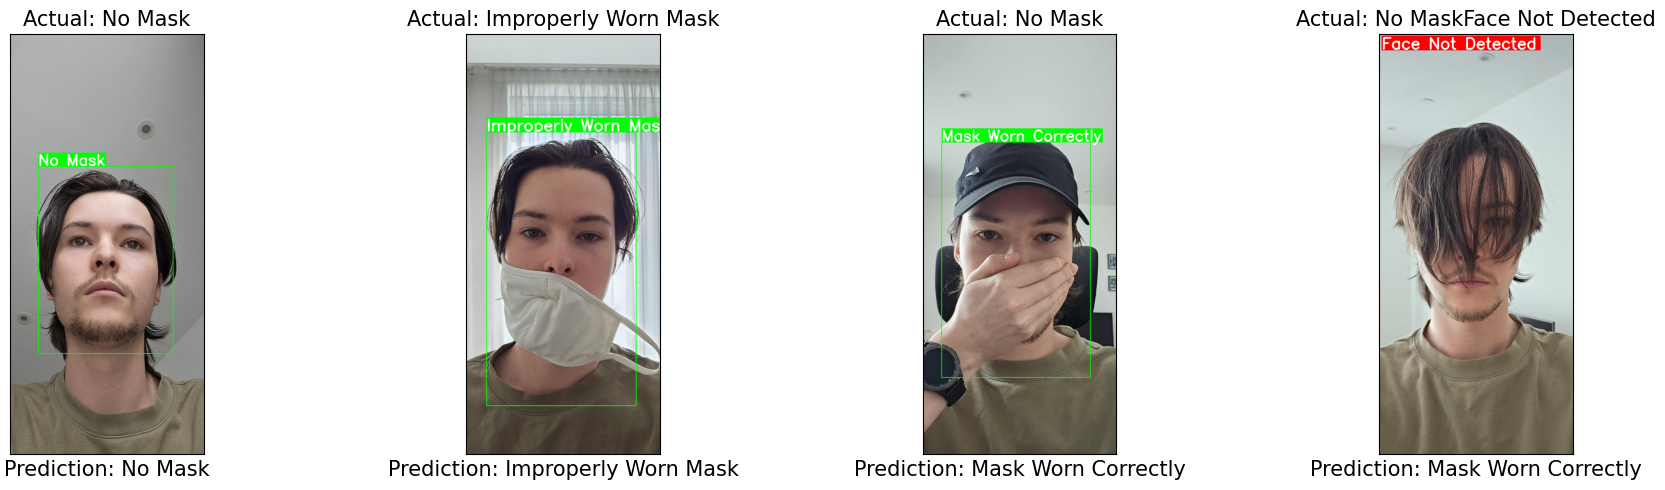

In [65]:
# Syntax for the next function is the following:
#
# MaskDetection(path_to_test)

# Path to test dataset
path_to_test = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')
# Run MaskDetection
MaskDetection(path_to_test)